In [1]:
import os
import tensorflow as tf
import keras

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname) 
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")]
)
target_path = sorted(
    [os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")]
)

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Allow GPU memory growth (recommended to avoid taking all GPU memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except (RuntimeError, FileNotFoundError, subprocess.CalledProcessError) as e:
        print(f"Error getting GPU info: {e}")
else:
    print("No GPU devices found")

keras.mixed_precision.set_global_policy('mixed_float16')

2025-01-09 13:24:26.253118: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-09 13:24:26.266039: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736396666.276849   94267 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736396666.280212   94267 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 13:24:26.292470: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


In [2]:
# defining a function to plot the training history
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.plot(accuracy, label='accuracy')
    ax1.plot(val_accuracy, label='val_accuracy')
    ax1.legend()

    ax2.plot(loss, label='loss')
    ax2.plot(val_loss, label='val_loss')
    ax2.legend()

    plt.legend()
    plt.show()

# defining a callback to save the best model
def checkpoint_save(filepath):
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = filepath,
        save_best_only = True,
        monitor = 'val_loss',
    )
    return checkpoint

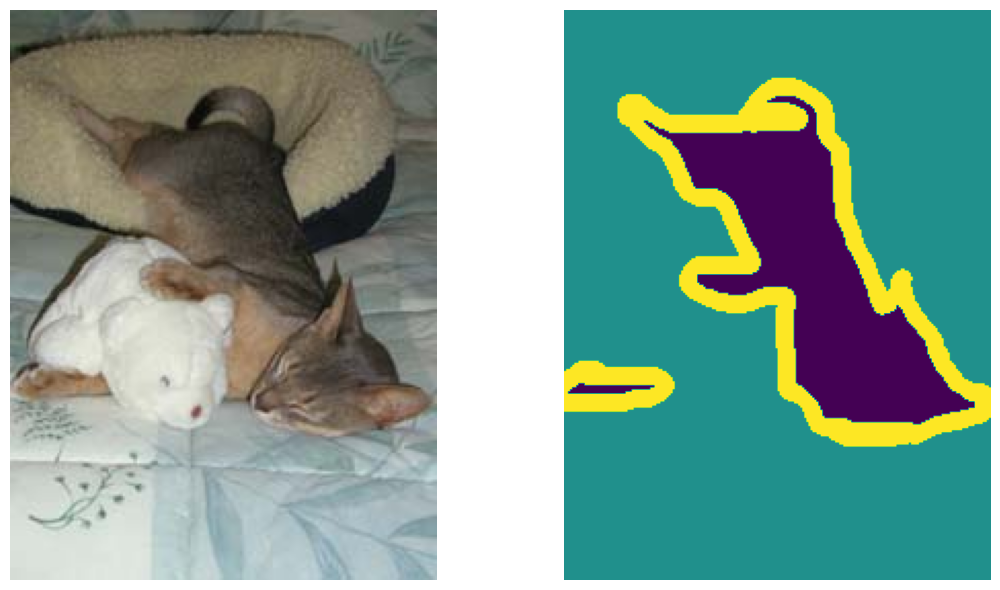

In [3]:
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array

def display_image_and_target(index):
    input_img = load_img(input_img_paths[index])

    target_img = load_img(target_path[index], color_mode="grayscale")
    target_img_array = img_to_array(target_img)
    target_img_normalized = (target_img_array.astype("uint8") - 1) * 127

    fig = plt.figure(figsize=(12, 6))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(input_img)
    ax1.axis("off")
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(target_img_normalized[:, :, 0])
    ax2.axis("off")
    
    plt.tight_layout()
    plt.show()


display_image_and_target(107)

In [4]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_path)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs, ) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs, ) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_path[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [5]:
from keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1.0 / 255)(inputs)
    
    x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    
    x = layers.Conv2DTranspose(256, 3, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
    
    output = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    
    model = keras.Model(inputs, output, name = "segmentation_model")
    return model

seg_model = get_model(img_size, num_classes = 3)
seg_model.summary()

I0000 00:00:1736396680.125194   94267 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9571 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "segmentation_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 25, 25, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 50, 50, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 128)  │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 100, 100, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 200, 200, 64)   │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,880,643 (10.99 MB)

 Trainable params: 2,880,643 (10.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
seg_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

seg_history = seg_model.fit(train_input_imgs, train_targets,
                            epochs=50,
                            callbacks=[checkpoint_save("seg_model.keras")],
                            batch_size=64,
                            validation_data=(val_input_imgs, val_targets))

Epoch 1/50


I0000 00:00:1736396684.386870   94470 service.cc:148] XLA service 0x7f2ff8018250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736396684.387202   94470 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-01-09 13:24:44.427012: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1736396684.468718   94470 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1736396684.690625   94470 cuda_dnn.cc:529] Loaded cuDNN version 90600
2025-01-09 13:24:58.006649: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=2} for conv (f16[128,3,3,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,50,50,128]{3,2,1,0}, f16[64,50,50,128]{3,2,1,0}), window={s

  3/100 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.4246 - loss: 1.0945   

2025-01-09 13:25:24.431086: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 136 bytes spill stores, 104 bytes spill loads

I0000 00:00:1736396724.440721   94470 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5735 - loss: 0.9710

W0000 00:00:1736396730.138000   94469 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-01-09 13:25:39.841170: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=4} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[54,100,100,64]{3,2,1,0}, f16[54,100,100,64]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-01-09 13:25:39.875397: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.035398973s
Trying algorithm eng19{k2=4} for conv (f16[64,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[54,100,100,6

In [ ]:
plot_history(seg_history)